<h1> NBA Player Improvement Predictor </h1> 

This project intends to build a prediction model to predict the year to year improvement of players. It will use the change in Win Share statistic as the target to be predicted. 

In order to predict the improvement of a player, we shall use the year to year change in Win Share value. Justification of this will be shown below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
Complete_df = pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\NBA Data\V2\Cleandf.csv')

In [3]:
features = Complete_df.columns.tolist()
features.remove('WS')
features.extend(['WS'])
Complete_df = Complete_df[features]
Complete_df.head(5)

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,WS
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43,0.0,290,55,...,14.0,22.1,0.0,0.5,0.079,-3.4,-1.2,-4.6,-0.2,0.5
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71,1.0,934,178,...,14.0,20.6,0.6,1.5,0.110,-2.3,-0.4,-2.6,-0.1,2.1
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75,52.0,1311,245,...,15.6,20.5,0.7,1.3,0.074,-2.4,-1.5,-3.9,-0.6,2.0
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13,0.0,159,24,...,20.5,22.6,-0.2,0.1,-0.032,-5.3,-2.2,-7.4,-0.2,-0.1
4,abdelal01,1995,Alaa Abdelnaby,PF,26,TOT,54,0.0,506,118,...,15.4,25.6,-0.4,0.7,0.027,-4.4,0.1,-4.3,-0.3,0.3


<h3> Adjusting for shorter seasons </h3> 

NBA Lockouts happened in the 1998-1999 season(50 games) and 2011-2012 season(66 games). Statistics of players during these 2 seasons tends to be lower than usual. Hence we shall normalize these. 


In [4]:

#remove OWS and DWS as WS is the addition of the 2
#remove TRB as it is the addition of ORB and DRB
#remove TRB%
#remove 3P%, 2P%, FG%, eFG%, FT%
#remove BPM (Box score plus minus) as its the sum of its Defensive and Offensive components
Complete_df.drop(['OWS','DWS','TRB','TRB%','3P%','2P%','FG%','eFG%','FT%','BPM'],axis = 1, inplace = True)
Complete_df.columns.tolist()

['Player ID',
 'Year',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 '3P',
 '3PA',
 '2P',
 '2PA',
 'FT',
 'FTA',
 'ORB',
 'DRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Season',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'WS/48',
 'OBPM',
 'DBPM',
 'VORP',
 'WS']

In [5]:
#features affected by shorter seasons
adjusted_features = ['G', 'GS', 'MP', 'WS', 'VORP',
                       'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                       'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV',
                       'PF', 'PTS','WS/48']

for col in adjusted_features:
    Complete_df.loc[Complete_df["Season"] == "2011-12",col] = Complete_df.loc[Complete_df["Season"] == "2011-12"][col] * (82/66)
    Complete_df.loc[Complete_df["Season"] == "1998-99",col] = Complete_df.loc[Complete_df["Season"] == "1998-99"][col] * (82/50)

<h3> Removing outliers </h3> 

When players get injured or have shorter seasons than their usual and they return to normal form next season, we see large increase in their WS value which results in outliers which needs to be removed from the dataset. This tends to happen for star players with high Value over replacement Player(VORP) values. Hence we shall check if a players VORP is greater than the 75% percentile of entire dataset, and then check if their Number of Games played for that year is less than one standard below the 25% percentile for a given player, and check if the WS value for a given player in that season is below the 25% percentile for that players statistics

In [6]:
player_grouping = Complete_df.groupby(['Player ID'])
VORP_75 = Complete_df["WS/48"].describe()["75%"]
key_list_players = list()

idx_shortseasons = list()
for key,group in player_grouping:
    key_list_players.append(key)

for key in key_list_players:
    temp = player_grouping.get_group(key)
    player_vorp = temp["VORP"].mean()
    twenty5thWS = temp["WS"].describe()["25%"]
    twenty5thG = temp["G"].describe()["25%"]
    stdG = temp["G"].describe()["std"]
    threshholdG = twenty5thG - stdG
    #dropping_idx = temp.loc[((temp["G"] < threshholdG) & (temp["WS/48"] < twenty5thWS48))].index.values.tolist()
    """ temp["deltaWS/48"] = temp[["WS"]].diff()
    deltaWS4825 = temp["deltaWS/48"].describe()["25%"]
    deltaWS4875 = temp["deltaWS/48"].describe()["75%"] """
    if(player_vorp > VORP_75):
        dropping_idx = temp.loc[((temp["G"] < threshholdG) & (temp["WS"] < twenty5thWS))].index.values.tolist()
        if len(dropping_idx) == 0:
            continue
        else:
            idx_shortseasons.extend(dropping_idx)
    else:
        continue

In [7]:
Complete_df.drop(idx_shortseasons, axis = 0, inplace = True)

In [8]:
#finding the year to year change in WS

Complete_df_delta = Complete_df.copy()
player_grouping = Complete_df_delta.groupby(['Player ID'])

key_list_players = list()


for key,group in player_grouping:
    key_list_players.append(key)

i = 0
deltaWS_df = None
for key in key_list_players:
    temp = player_grouping.get_group(key)
    deltaWS = temp[["WS"]].diff()[1:]
    idx = temp.index.values.tolist()
    deltaWS.index = idx[:-1]
    temp = temp.iloc[:-1,:-1]
    temp["deltaWS"] = deltaWS
    if i == 0:
        deltaWS_df = temp
        i = 1
    else:
        deltaWS_df = pd.concat([deltaWS_df,temp], axis = 0)

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='deltaWS'>

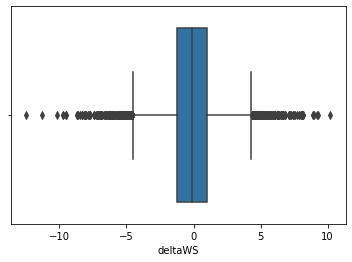

In [9]:
sns.boxplot(deltaWS_df["deltaWS"])

In [10]:
deltaWS_df.reset_index(drop = True, inplace = True)
deltaWS_df.to_csv("DeltaWS.csv",index = False)

Now we have made the dataset to include the target variable for Predicting Player improvement. 

The year to year change in Win Shares(WS) of each player is selected as the target variable. The following analysis justifies why year to year change in WS is selected. 

The following analysis shows that the change in WS is often the highest in players who won the Most Improved Player award. 

In [11]:
import unidecode
deltaWS_df_mip = deltaWS_df.copy()
mip_data = pd.read_csv("MIP.csv")
mip_data["Won MIP"] = int(1)
mip_data.drop(['Lg'],axis = 1, inplace = True)
mip_data["Player"] = mip_data["Player"].apply(lambda x: unidecode.unidecode(x))
mip_data

,Season,Player,Won MIP
0,2018-19,Pascal Siakam,1
1,2017-18,Victor Oladipo,1
2,2016-17,Giannis Antetokounmpo,1
3,2015-16,CJ McCollum,1
4,2014-15,Jimmy Butler,1
5,2013-14,Goran Dragic,1
6,2012-13,Paul George,1
7,2011-12,Ryan Anderson,1
8,2010-11,Kevin Love,1
9,2009-10,Aaron Brooks,1


In [12]:
mip_data.columns = ["Year","Player","Won MIP"]

In [13]:
mip_data["Year"] = mip_data["Year"].apply(lambda x: str(x.split('-')[0]))
mip_data

,Year,Player,Won MIP
0,2018,Pascal Siakam,1
1,2017,Victor Oladipo,1
2,2016,Giannis Antetokounmpo,1
3,2015,CJ McCollum,1
4,2014,Jimmy Butler,1
5,2013,Goran Dragic,1
6,2012,Paul George,1
7,2011,Ryan Anderson,1
8,2010,Kevin Love,1
9,2009,Aaron Brooks,1


In [14]:
mip_data["Year"] = mip_data["Year"].astype(int)
mip_data["Year"].dtype

dtype('int32')

In [15]:
deltaWS_df_mip = pd.merge(deltaWS_df_mip,mip_data, how = 'left', on = ["Year", "Player"])
deltaWS_df_mip

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,VORP,deltaWS,Won MIP
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43.0,0.000000,290.0,55.0,...,0.7,2.5,14.0,22.1,0.079,-3.4,-1.2,-0.2,1.6,NaN
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71.0,1.000000,934.0,178.0,...,1.3,1.1,14.0,20.6,0.110,-2.3,-0.4,-0.1,-0.1,NaN
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75.0,52.000000,1311.0,245.0,...,1.0,1.2,15.6,20.5,0.074,-2.4,-1.5,-0.6,-2.1,NaN
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13.0,0.000000,159.0,24.0,...,0.6,1.2,20.5,22.6,-0.032,-5.3,-2.2,-0.2,0.4,NaN
4,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82.0,79.666667,3143.0,835.0,...,1.2,4.6,15.7,24.1,0.227,4.8,2.4,7.3,-0.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12631,zidekge01,1997,George Zidek,C,23,TOT,52.0,2.000000,376.0,49.0,...,0.7,0.6,15.9,21.0,0.034,-4.4,-2.6,-0.5,-0.3,NaN
12632,zipsepa01,2017,Paul Zipser,SF,22,CHI,44.0,18.000000,843.0,88.0,...,0.9,1.5,14.4,14.4,0.030,-4.2,-0.2,-0.5,-1.1,NaN
12633,zizican01,2018,Ante Zizic,C,21,CLE,32.0,2.000000,214.0,49.0,...,0.5,5.2,12.1,18.8,0.231,1.9,-0.9,0.2,1.0,NaN
12634,zubaciv01,2017,Ivica Zubac,C,19,LAL,38.0,11.000000,609.0,126.0,...,1.1,4.4,10.4,20.3,0.086,-1.2,-0.6,0.0,-0.1,NaN


In [16]:
deltaWS_df_mip.loc[deltaWS_df_mip["Won MIP"].isna(),'Won MIP'] = int(0)
deltaWS_df_mip

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,STL%,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,VORP,deltaWS,Won MIP
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43.0,0.000000,290.0,55.0,...,0.7,2.5,14.0,22.1,0.079,-3.4,-1.2,-0.2,1.6,0.0
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71.0,1.000000,934.0,178.0,...,1.3,1.1,14.0,20.6,0.110,-2.3,-0.4,-0.1,-0.1,0.0
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75.0,52.000000,1311.0,245.0,...,1.0,1.2,15.6,20.5,0.074,-2.4,-1.5,-0.6,-2.1,0.0
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13.0,0.000000,159.0,24.0,...,0.6,1.2,20.5,22.6,-0.032,-5.3,-2.2,-0.2,0.4,0.0
4,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82.0,79.666667,3143.0,835.0,...,1.2,4.6,15.7,24.1,0.227,4.8,2.4,7.3,-0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12631,zidekge01,1997,George Zidek,C,23,TOT,52.0,2.000000,376.0,49.0,...,0.7,0.6,15.9,21.0,0.034,-4.4,-2.6,-0.5,-0.3,0.0
12632,zipsepa01,2017,Paul Zipser,SF,22,CHI,44.0,18.000000,843.0,88.0,...,0.9,1.5,14.4,14.4,0.030,-4.2,-0.2,-0.5,-1.1,0.0
12633,zizican01,2018,Ante Zizic,C,21,CLE,32.0,2.000000,214.0,49.0,...,0.5,5.2,12.1,18.8,0.231,1.9,-0.9,0.2,1.0,0.0
12634,zubaciv01,2017,Ivica Zubac,C,19,LAL,38.0,11.000000,609.0,126.0,...,1.1,4.4,10.4,20.3,0.086,-1.2,-0.6,0.0,-0.1,0.0


In [17]:
rank_groups = deltaWS_df_mip.groupby('Season')
rank_groups_keys = list()

for key,group in rank_groups:
    rank_groups_keys.append(key)

i = 0
for key in rank_groups_keys:
    temp = rank_groups.get_group(key)
    temp["deltaWS_Rank"] = temp["deltaWS"].rank(ascending = True)
    temp.sort_values(by = "deltaWS_Rank",inplace = True, ascending = False)
    if i==0:
        df_WS_rank = temp
        i = 1
    else:
        df_WS_rank = df_WS_rank.append(temp,ignore_index=True)

<ipython-input-17-da8bc8414eac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["deltaWS_Rank"] = temp["deltaWS"].rank(ascending = True)
<ipython-input-17-da8bc8414eac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.sort_values(by = "deltaWS_Rank",inplace = True, ascending = False)


In [18]:
grouped_seasonal = df_WS_rank.groupby('Season')
key_list_seasonal = list()

for key,group in grouped_seasonal:
    key_list_seasonal.append(key)
ws_highest_rank = list()
season_list = list()
for key in key_list_seasonal:
    temp = grouped_seasonal.get_group(key)
    #getting the maximum change in WS for each year
    ws_highest_rank.append(temp["deltaWS_Rank"].max())
    season_list.append(key)
maximum_ws_seasonal = pd.DataFrame({"Season":season_list,"Highest WS Rank":ws_highest_rank})
maximum_ws_seasonal

,Season,Highest WS Rank
0,1979-80,220.0
1,1980-81,246.0
2,1981-82,249.0
3,1982-83,245.0
4,1983-84,248.0
5,1984-85,259.0
6,1985-86,246.0
7,1986-87,259.0
8,1987-88,255.0
9,1988-89,283.5


In [19]:
df_WS_rank = df_WS_rank.loc[df_WS_rank["Won MIP"] == 1]
df_WS_rank

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,BLK%,TOV%,USG%,WS/48,OBPM,DBPM,VORP,deltaWS,Won MIP,deltaWS_Rank
1208,roberal01,1985,Alvin Robertson,SG,22,SAS,79.00,9.00,1685.000000,299.000000,...,0.8,19.8,20.0,0.087000,-0.2,1.1,1.200000,5.500000,1.0,259.0
1467,ellisda01,1986,Dale Ellis,SF,25,DAL,72.00,1.00,1086.000000,193.000000,...,0.4,7.0,20.4,0.071000,1.1,-2.0,0.300000,7.700000,1.0,246.0
1720,duckwke01,1987,Kevin Duckworth,C,22,TOT,65.00,1.00,875.000000,130.000000,...,1.3,19.0,18.5,0.045000,-5.1,-0.9,-0.900000,4.400000,1.0,252.0
1972,johnske02,1988,Kevin Johnson,PG,21,TOT,80.00,28.00,1917.000000,275.000000,...,0.7,17.5,18.2,0.101000,0.3,0.6,1.400000,8.200000,1.0,255.0
2235,seikaro01,1989,Rony Seikaly,C,23,MIA,78.00,62.00,1962.000000,333.000000,...,3.0,18.2,22.8,-0.012000,-4.4,-1.3,-1.900000,3.700000,1.0,275.0
2516,skilesc01,1990,Scott Skiles,PG,25,ORL,70.00,32.00,1460.000000,190.000000,...,0.2,14.8,16.2,0.065000,-0.2,-1.9,0.000000,5.000000,1.0,298.5
2837,ellispe01,1991,Pervis Ellison,C,23,WSB,76.00,30.00,1942.000000,326.000000,...,4.8,16.7,18.8,0.100000,-1.5,0.9,0.700000,2.900000,1.0,287.5
3129,abdulma02,1992,Mahmoud Abdul-Rauf,PG,22,DEN,81.00,11.00,1538.000000,356.000000,...,0.2,11.6,26.7,0.018000,-1.2,-1.9,-0.400000,4.500000,1.0,302.0
3437,macledo01,1993,Don MacLean,PF,23,WSB,62.00,4.00,674.000000,157.000000,...,0.4,9.3,28.5,0.030000,-2.0,-2.7,-0.500000,5.200000,1.0,299.5
3736,barroda01,1994,Dana Barros,PG,26,PHI,81.00,70.00,2519.000000,412.000000,...,0.1,15.1,19.1,0.089000,1.7,-1.1,1.700000,8.000000,1.0,324.0


<ipython-input-20-4bd6d063cd35>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mip.set_xticklabels(labels, rotation = 45)


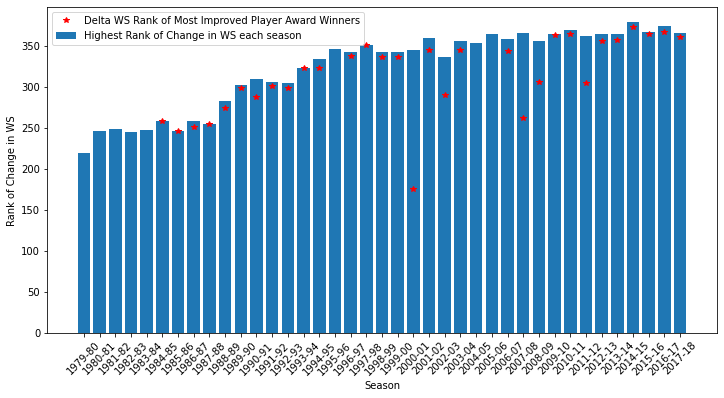

In [20]:
fig,ax_mip = plt.subplots(1,1,figsize = (12,6))
ax_mip.bar(maximum_ws_seasonal["Season"],maximum_ws_seasonal["Highest WS Rank"], label="Highest Rank of Change in WS each season")
ax_mip.plot(df_WS_rank["Season"],df_WS_rank["deltaWS_Rank"],'r*', label = 'Delta WS Rank of Most Improved Player Award Winners')
labels = maximum_ws_seasonal["Season"].unique().tolist()
ax_mip.set_xticklabels(labels, rotation = 45)
ax_mip.set_xlabel("Season")
ax_mip.set_ylabel("Rank of Change in WS")
ax_mip.legend()
plt.show()

In a vast majority of the seasons, players with large increases in Win Share values on a year to year basis, are also the players who end up winning the Most Improved Player Award. 

<h3> Checking for outliers with distorted statistics </h3> 
Checking for players who had very little playing time, however ended up with distorted statistics. This can occur in rate statistics usually where play time is not takes to consideration and players who have have very low minutes end up posting strong statistics (e.g: players making one 3P from one 3PA will have 100% 3PA which is better than the leagues best scorers)

Statistics to investigate:

- PER
- TS%
- 3PAr
- FTr
- ORB%
- DRB%
- AST%
- STL%
- TOV%
- USG%
- BPM

In [21]:
outlier_df = deltaWS_df.copy()
outlier_df["BPM"] = outlier_df["OBPM"] + outlier_df["DBPM"]

<h3> PER : Player Efficiency Rating</h3>

<AxesSubplot:xlabel='MP', ylabel='Count'>

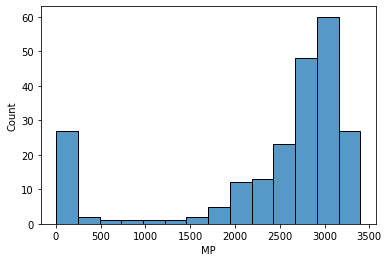

In [22]:
sns.histplot(outlier_df.loc[outlier_df["PER"] > outlier_df["PER"].describe()["75%"] + 1.5*(outlier_df["PER"].describe()["75%"] - outlier_df["PER"].describe()["25%"])]["MP"])

There are roughly 27 players with very low MP but very high PER values. 

In [23]:
PER_df = outlier_df.loc[outlier_df["PER"] > outlier_df["PER"].describe()["75%"] + 1.5*(outlier_df["PER"].describe()["75%"] - outlier_df["PER"].describe()["25%"])]

print("Average Minutes Player: {}".format(PER_df.loc[PER_df["MP"] < 250]["MP"].mean()))
print("Average PER : {}".format(PER_df.loc[PER_df["MP"] < 250]["PER"].mean()))
print("League Average PER: {}".format(outlier_df["PER"].mean()))

Average Minutes Player: 23.717037037037038
Average PER : 41.4037037037037
League Average PER: 13.640914846470402


As seen above, the league average is just 13.6, and players who have played on average 23 minutes for the ENTIRE SEASON, have PER of 43. These are outliers, hence will be removed from the main dataset.

In [24]:
per_idx = PER_df.loc[PER_df["MP"] < 250].index.tolist()

<h3> TS% : True Shooting Percentage </h3> 

<AxesSubplot:xlabel='MP', ylabel='Count'>

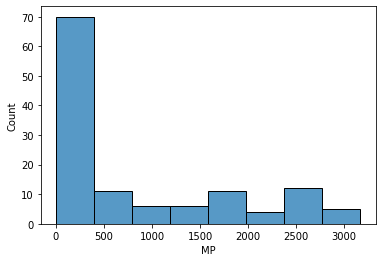

In [25]:
sns.histplot(outlier_df.loc[outlier_df["TS%"] > outlier_df["TS%"].describe()["75%"] + 1.5*(outlier_df["TS%"].describe()["75%"] - outlier_df["TS%"].describe()["25%"])]["MP"])

In [26]:
TS_df = outlier_df.loc[outlier_df["TS%"] > outlier_df["TS%"].describe()["75%"] + 1.5*(outlier_df["TS%"].describe()["75%"] - outlier_df["TS%"].describe()["25%"])]

print("Average Minutes Player: {}".format(TS_df.loc[TS_df["MP"] < 250]["MP"].mean()))
print("Average TS% : {}".format(TS_df.loc[TS_df["MP"] < 250]["TS%"].mean()))
print("League Average TS%: {}".format(outlier_df["TS%"].mean()))

Average Minutes Player: 58.62268656716418
Average TS% : 0.788865671641791
League Average TS%: 0.5205407565685344


In [27]:
ts_idx = TS_df.loc[TS_df["MP"] < 250].index.tolist()

<h3> 3 Point Attempt Rate </h3>

<AxesSubplot:xlabel='MP', ylabel='Count'>

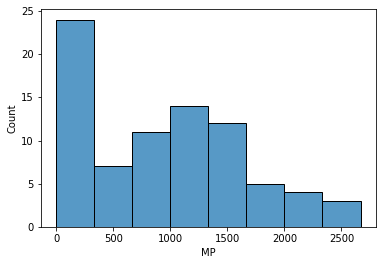

In [28]:
sns.histplot(outlier_df.loc[outlier_df["3PAr"] > outlier_df["3PAr"].describe()["75%"] + 1.5*(outlier_df["3PAr"].describe()["75%"] - outlier_df["3PAr"].describe()["25%"])]["MP"])

In [29]:
threepar_df = outlier_df.loc[outlier_df["3PAr"] > outlier_df["3PAr"].describe()["75%"] + 1.5*(outlier_df["3PAr"].describe()["75%"] - outlier_df["3PAr"].describe()["25%"])]

print("Average Minutes Player: {}".format(threepar_df.loc[threepar_df["MP"] < 250]["MP"].mean()))
print("Average 3PAr : {}".format(threepar_df.loc[threepar_df["MP"] < 250]["3PAr"].mean()))
print("League Average 3PAr: {}".format(outlier_df["3PAr"].mean()))

Average Minutes Player: 108.35
Average 3PAr : 0.8461500000000001
League Average 3PAr: 0.15799446027223807


<h3> Free Throw Rate </h3>

<AxesSubplot:xlabel='MP', ylabel='Count'>

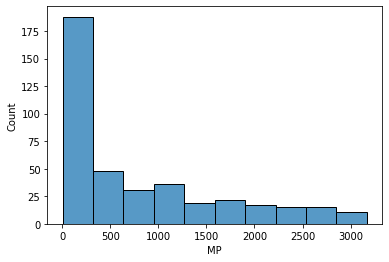

In [30]:
sns.histplot(outlier_df.loc[outlier_df["FTr"] > outlier_df["FTr"].describe()["75%"] + 1.5*(outlier_df["FTr"].describe()["75%"] - outlier_df["FTr"].describe()["25%"])]["MP"])

In [31]:
freetar_df = outlier_df.loc[outlier_df["FTr"] > outlier_df["FTr"].describe()["75%"] + 1.5*(outlier_df["FTr"].describe()["75%"] - outlier_df["FTr"].describe()["25%"])]

print("Average Minutes Player: {}".format(freetar_df.loc[freetar_df["MP"] < 250]["MP"].mean()))
print("Average FTr : {}".format(freetar_df.loc[freetar_df["MP"] < 250]["FTr"].mean()))
print("League Average FTr: {}".format(outlier_df["FTr"].mean()))

Average Minutes Player: 88.43420014094433
Average FTr : 1.0309651162790698
League Average FTr: 0.3204026590693257


Both 3PAr and FTr are features that only take "Attempts" into consideration and show no difference between a player making an impact and a scrub player. Hence these features will be dropped. 

In [32]:
deltaWS_df.drop(['3PAr', 'FTr'], axis = 1, inplace = True )

<h3> ORB% : Offensive Rebound Percentage </h3> 

Offensive rebound percentage is an estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor.

As its a percentage, if a player who was on the floor for a few minutes but got a few rebounds in, would end up having a large ORB%

<AxesSubplot:xlabel='MP', ylabel='Count'>

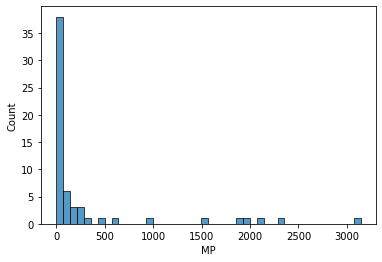

In [33]:
sns.histplot(outlier_df.loc[outlier_df["ORB%"] > outlier_df["ORB%"].describe()["75%"] + 1.5*(outlier_df["ORB%"].describe()["75%"] - outlier_df["ORB%"].describe()["25%"])]["MP"])

The above Histogram shows how distorted this statistic is. Players with very few playing minutes tend to be the players with ORB% values outside the 75% + 1.5(Interquartile Range).

In [34]:
orb_df = outlier_df.loc[outlier_df["ORB%"] > outlier_df["ORB%"].describe()["75%"] + 1.5*(outlier_df["ORB%"].describe()["75%"] - outlier_df["ORB%"].describe()["25%"])]

print("Average Minutes Player: {}".format(orb_df.loc[orb_df["MP"] < 250]["MP"].mean()))
print("Average ORB% : {}".format(orb_df.loc[orb_df["MP"] < 250]["ORB%"].mean()))
print("League Average ORB%: {}".format(outlier_df["ORB%"].mean()))

Average Minutes Player: 46.419999999999995
Average ORB% : 31.489583333333332
League Average ORB%: 6.2129392212725545


In [35]:
orb_idx = orb_df.loc[orb_df["MP"] < 250].index.tolist()

<h3> DRB% : Defensive Rebound Percentage </h3> 

Defensive rebound percentage is an estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor.

<AxesSubplot:xlabel='MP', ylabel='Count'>

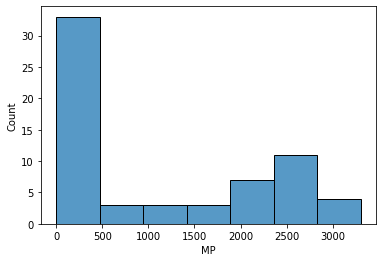

In [36]:
sns.histplot(outlier_df.loc[outlier_df["DRB%"] > outlier_df["DRB%"].describe()["75%"] + 1.5*(outlier_df["DRB%"].describe()["75%"] - outlier_df["DRB%"].describe()["25%"])]["MP"])

Just like in Offensive Rebound Percentage, most of the players with high DRB% have very low Minutes Played.

In [37]:
drb_df = outlier_df.loc[outlier_df["DRB%"] > outlier_df["DRB%"].describe()["75%"] + 1.5*(outlier_df["DRB%"].describe()["75%"] - outlier_df["DRB%"].describe()["25%"])]

print("Average Minutes Player: {}".format(drb_df.loc[drb_df["MP"] < 250]["MP"].mean()))
print("Average DRB% : {}".format(drb_df.loc[drb_df["MP"] < 250]["DRB%"].mean()))
print("League Average DRB%: {}".format(outlier_df["DRB%"].mean()))

Average Minutes Player: 26.166666666666668
Average DRB% : 44.063333333333325
League Average DRB%: 14.101946818613486


In [38]:
drb_idx = drb_df.loc[drb_df["MP"] < 250].index.tolist()

<h3> AST% : Assist Percentage </h3> 

Assist percentage is an estimate of the percentage of teammate field goals a player assisted while he was on the floor.

<AxesSubplot:xlabel='MP', ylabel='Count'>

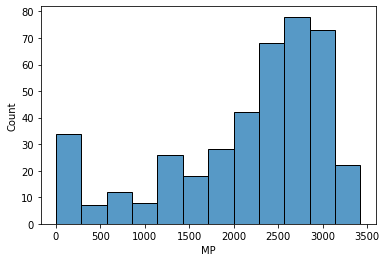

In [39]:
sns.histplot(outlier_df.loc[outlier_df["AST%"] > outlier_df["AST%"].describe()["75%"] + 1.5*(outlier_df["AST%"].describe()["75%"] - outlier_df["AST%"].describe()["25%"])]["MP"])

In [40]:
ast_df = outlier_df.loc[outlier_df["AST%"] > outlier_df["AST%"].describe()["75%"] + 1.5*(outlier_df["AST%"].describe()["75%"] - outlier_df["AST%"].describe()["25%"])]

print("Average Minutes Player: {}".format(ast_df.loc[ast_df["MP"] < 250]["MP"].mean()))
print("Average AST% : {}".format(ast_df.loc[ast_df["MP"] < 250]["AST%"].mean()))
print("League Average AST%: {}".format(outlier_df["AST%"].mean()))

Average Minutes Player: 71.93784090909091
Average AST% : 44.446875000000006
League Average AST%: 13.470196264640709


In [41]:
ast_idx = ast_df.loc[ast_df["MP"] < 250].index.tolist()

<h3> STL% : Steal Percentage </h3> 

Steal Percentage is an estimate of the percentage of opponent possessions that end with a steal by the player while he was on the floor.

<AxesSubplot:xlabel='MP', ylabel='Count'>

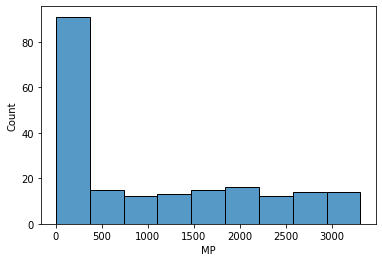

In [42]:
sns.histplot(outlier_df.loc[outlier_df["STL%"] > outlier_df["STL%"].describe()["75%"] + 1.5*(outlier_df["STL%"].describe()["75%"] - outlier_df["STL%"].describe()["25%"])]["MP"])

In [43]:
stl_df = outlier_df.loc[outlier_df["STL%"] > outlier_df["STL%"].describe()["75%"] + 1.5*(outlier_df["STL%"].describe()["75%"] - outlier_df["STL%"].describe()["25%"])]

print("Average Minutes Player: {}".format(stl_df.loc[stl_df["MP"] < 250]["MP"].mean()))
print("Average STL% : {}".format(stl_df.loc[stl_df["MP"] < 250]["STL%"].mean()))
print("League Average STL%: {}".format(outlier_df["STL%"].mean()))

Average Minutes Player: 59.59855421686748
Average STL% : 5.975903614457831
League Average STL%: 1.6613089585311807


In [44]:
stl_idx = stl_df.loc[stl_df["MP"] < 250].index.tolist()

<h3> TOV% : Turnover percentage </h3> 

Turnover percentage is an estimate of turnovers per 100 plays.

<AxesSubplot:xlabel='MP', ylabel='Count'>

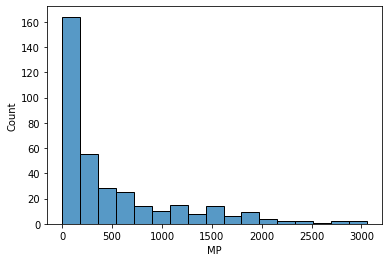

In [45]:
sns.histplot(outlier_df.loc[outlier_df["TOV%"] > outlier_df["TOV%"].describe()["75%"] + 1.5*(outlier_df["TOV%"].describe()["75%"] - outlier_df["TOV%"].describe()["25%"])]["MP"])

In [46]:
tov_df = outlier_df.loc[outlier_df["TOV%"] > outlier_df["TOV%"].describe()["75%"] + 1.5*(outlier_df["TOV%"].describe()["75%"] - outlier_df["TOV%"].describe()["25%"])]

print("Average Minutes Player: {}".format(tov_df.loc[tov_df["MP"] < 250]["MP"].mean()))
print("Average TOV% : {}".format(tov_df.loc[tov_df["MP"] < 250]["TOV%"].mean()))
print("League Average TOV%: {}".format(outlier_df["TOV%"].mean()))

Average Minutes Player: 87.61804713804712
Average TOV% : 33.04867724867725
League Average TOV%: 14.4704495093384


In [47]:
tov_idx = tov_df.loc[tov_df["MP"] < 250].index.tolist()

<h3> USG% : Usage Percentage </h3> 

Usage percentage is an estimate of the percentage of team plays used by a player while he was on the floor.

<AxesSubplot:xlabel='MP', ylabel='Count'>

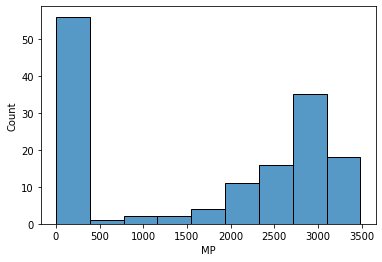

In [48]:
sns.histplot(outlier_df.loc[outlier_df["USG%"] > outlier_df["USG%"].describe()["75%"] + 1.5*(outlier_df["USG%"].describe()["75%"] - outlier_df["USG%"].describe()["25%"])]["MP"])

In [49]:
usg_df = outlier_df.loc[outlier_df["USG%"] > outlier_df["USG%"].describe()["75%"] + 1.5*(outlier_df["USG%"].describe()["75%"] - outlier_df["USG%"].describe()["25%"])]

print("Average Minutes Player: {}".format(usg_df.loc[usg_df["MP"] < 250]["MP"].mean()))
print("Average USG% : {}".format(usg_df.loc[usg_df["MP"] < 250]["USG%"].mean()))
print("League Average USG%: {}".format(outlier_df["USG%"].mean()))

Average Minutes Player: 32.71037037037037
Average USG% : 39.32592592592593
League Average USG%: 19.174430199430198


In [50]:
usg_idx = usg_df.loc[usg_df["MP"] < 250].index.tolist()

<h3> Offensive Box Score Plus Minus </h3> 


<AxesSubplot:xlabel='MP', ylabel='Count'>

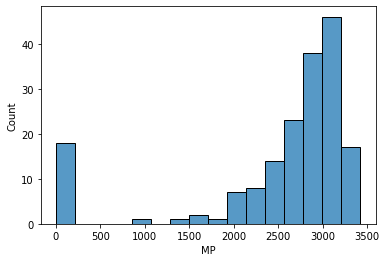

In [51]:
sns.histplot(outlier_df.loc[outlier_df["OBPM"] > outlier_df["OBPM"].describe()["75%"] + 1.5*(outlier_df["OBPM"].describe()["75%"] - outlier_df["OBPM"].describe()["25%"])]["MP"])

In [52]:
obpm_df = outlier_df.loc[outlier_df["OBPM"] > outlier_df["OBPM"].describe()["75%"] + 1.5*(outlier_df["OBPM"].describe()["75%"] - outlier_df["OBPM"].describe()["25%"])]

print("Average Minutes Player: {}".format(obpm_df.loc[obpm_df["MP"] < 250]["MP"].mean()))
print("Average OBPM : {}".format(obpm_df.loc[obpm_df["MP"] < 250]["OBPM"].mean()))
print("League Average OBPM: {}".format(outlier_df["OBPM"].mean()))

Average Minutes Player: 21.26888888888889
Average OBPM : 23.905555555555555
League Average OBPM: -0.9538936372269706


In [53]:
obpm_idx = obpm_df.loc[obpm_df["MP"] < 250].index.tolist()

<h3> Defensive Box Score Plus Minus </h3> 


<AxesSubplot:xlabel='MP', ylabel='Count'>

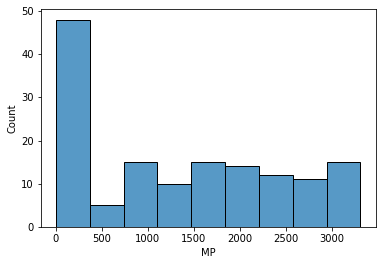

In [54]:
sns.histplot(outlier_df.loc[outlier_df["DBPM"] > outlier_df["DBPM"].describe()["75%"] + 1.5*(outlier_df["DBPM"].describe()["75%"] - outlier_df["DBPM"].describe()["25%"])]["MP"])

In [55]:
dbpm_df = outlier_df.loc[outlier_df["DBPM"] > outlier_df["DBPM"].describe()["75%"] + 1.5*(outlier_df["DBPM"].describe()["75%"] - outlier_df["DBPM"].describe()["25%"])]

print("Average Minutes Player: {}".format(dbpm_df.loc[dbpm_df["MP"] < 250]["MP"].mean()))
print("Average DBPM : {}".format(dbpm_df.loc[dbpm_df["MP"] < 250]["DBPM"].mean()))
print("League Average DBPM: {}".format(outlier_df["DBPM"].mean()))

Average Minutes Player: 38.49527272727273
Average DBPM : 6.6288888888888895
League Average DBPM: -0.08201171256726812


In [56]:
dbpm_idx = dbpm_df.loc[dbpm_df["MP"] < 250].index.tolist()

In [57]:
outliers_idx = list()

outliers_list = [per_idx,ts_idx,orb_idx,drb_idx,ast_idx,stl_idx,tov_idx,usg_idx,obpm_idx,dbpm_idx]

for feature_idx in outliers_list:
    outliers_idx.extend(feature_idx)

In [58]:
outliers_idx_to_remove = list(set(outliers_idx))

In [59]:
deltaWS_df.drop(outliers_idx_to_remove, axis = 0, inplace=True)

In [60]:
deltaWS_df.columns.tolist()

['Player ID',
 'Year',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 '3P',
 '3PA',
 '2P',
 '2PA',
 'FT',
 'FTA',
 'ORB',
 'DRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Season',
 'PER',
 'TS%',
 'ORB%',
 'DRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'WS/48',
 'OBPM',
 'DBPM',
 'VORP',
 'deltaWS']

<h3> Keeping essential features </h3> 
Given that most outliers have been removed prior to this, now we shall remove features that are redundant. 

- ORB,TRB, AST, STL, BLK, TOV are all totals, where as their percentage values take into account the total, the teams total minutes played and in the case of rebounds, the available opposition and team rebounds. Hence the % give a better idea of the players performance, hence the totals will be removed. 

- USG % =  100 * ((FGA + 0.44 * FTA + TOV) * (Tm MP / 5)) / (MP * (Tm FGA + 0.44 * Tm FTA + Tm TOV)). If the correlation between Usage % and FGA, FTA is strong, we shall remove FGA, FTA while keeping USG%.

- BPM (OBPM + DBPM), VORP, PER all try to show players overall performance. We shall investigate the correlations. If highly correlated, remove VORP, PER and keep OBPM and DBPM.

In [61]:
#removing percentage features
deltaWS_df.drop(['ORB',
 'DRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 ], axis = 1, inplace=True)

<AxesSubplot:>

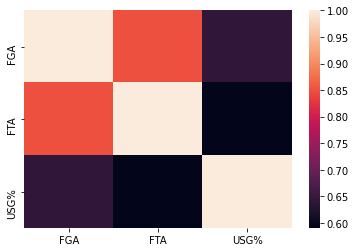

In [62]:
sns.heatmap(deltaWS_df[["FGA","FTA","USG%"]].corr())

In [63]:
from scipy.stats import pearsonr
corr_fga, pval_fga = pearsonr(deltaWS_df["FGA"], deltaWS_df["USG%"])
print("FGA to USG% : {}".format(corr_fga))
print("FGA to USG% pvalue : {}".format(pval_fga))

FGA to USG% : 0.6421037528948906
FGA to USG% pvalue : 0.0


In [64]:
from scipy.stats import pearsonr
corr_fta, pval_fta = pearsonr(deltaWS_df["FTA"], deltaWS_df["USG%"])
print("FTA to USG% : {}".format(corr_fta))
print("FTA to USG% pvalue : {}".format(pval_fta))

FTA to USG% : 0.5908485605818552
FTA to USG% pvalue : 0.0


As shown above, USG% is directly correlated with FGA and FTA and the it is statistically significant as pvalue is below 0.05. 

In [65]:
deltaWS_df.drop(["FTA","FGA"], axis = 1, inplace = True)

In [66]:
deltaWS_df["BPM"] = deltaWS_df["OBPM"] + deltaWS_df["DBPM"]

<AxesSubplot:>

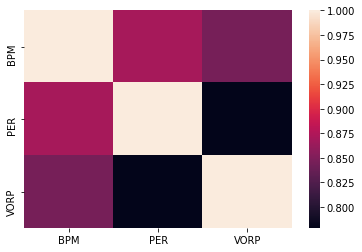

In [67]:
sns.heatmap(deltaWS_df[["BPM","PER","VORP"]].corr())

In [68]:
from scipy.stats import pearsonr
corr_vorp, pval_vorp = pearsonr(deltaWS_df["VORP"], deltaWS_df["BPM"])
print("VORP to BPM : {}".format(corr_vorp))
print("VORP to BPM pvalue : {}".format(pval_vorp))

VORP to BPM : 0.8457041680748625
VORP to BPM pvalue : 0.0


In [69]:
corr_per, pval_per = pearsonr(deltaWS_df["PER"], deltaWS_df["BPM"])
print("PER to BPM : {}".format(corr_per))
print("PER to BPM pvalue : {}".format(pval_per))

PER to BPM : 0.8703139882885742
PER to BPM pvalue : 0.0


Both PER and VORP have strong correlations to player performance. Hence we shall drop PER and VORP and keep OBPM and DBPM.

In [70]:
deltaWS_df.drop(["BPM","PER","VORP"],axis = 1, inplace = True)

<h3> Investigating correlation between other features </h3> 

Text(0.5, 1.0, 'Feature Correlation')

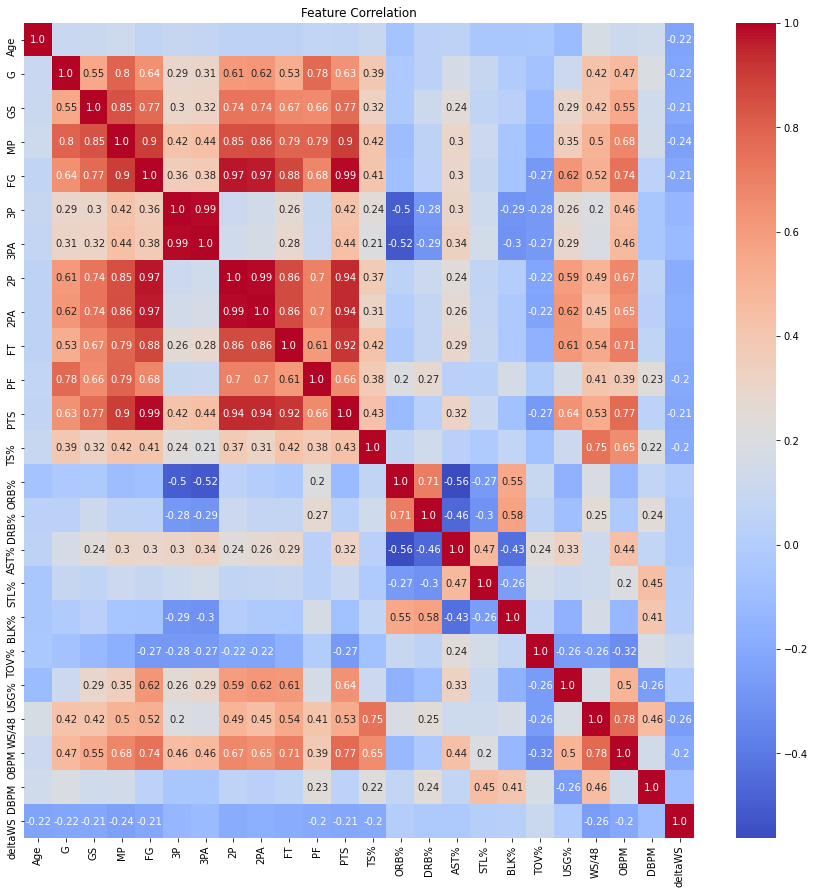

In [71]:
fig,ax_heatmap = plt.subplots(1,1,figsize = (15,15))
features_numerical = [i for i in deltaWS_df.columns.tolist() if ((deltaWS_df[i].dtype == 'float64') or (deltaWS_df[i].dtype == 'int32'))]
features_numerical.insert(0,'Age')
correl = deltaWS_df[features_numerical].corr()
correl_annot = correl.round(2)
correl_annot[correl_annot.abs() < 0.2] = ""
snsheatmap = sns.heatmap(correl,annot = correl_annot, cmap = 'coolwarm',ax = ax_heatmap, fmt = '')
ax_heatmap.set_title('Feature Correlation')

<h3> Takeaways </h3> 

- PTS has a strong correlation with all the other shooting attributes(3P, 2P, FG, FT).  
- As a player plays more minutes, other features also increase. Hence it is required we get "/minute" attributes. 
- ORB% and DRB% are highly correlated to each other. We shall combine to Total Rebound% (TRB%) and drop these 2 features.
- TS% is correlated to the other shooting attributes. Given that this attribute takes a players shooting skills intoconsideration, we shall drop 3P, 2P, FG, FT

In [72]:
deltaWS_df["GS%"] = deltaWS_df["GS"]/deltaWS_df["G"]
deltaWS_df["TRB%"] = deltaWS_df["ORB%"] + deltaWS_df["DRB%"]
deltaWS_df["3PA/48"] = 48*(deltaWS_df["3PA"]/deltaWS_df["MP"])
deltaWS_df["2PA/48"] = 48*(deltaWS_df["2PA"]/deltaWS_df["MP"])
deltaWS_df["PF/48"] = 48*(deltaWS_df["PF"]/deltaWS_df["MP"])
deltaWS_df["MP/Game"] = deltaWS_df["MP"]/deltaWS_df["G"]
deltaWS_df.drop(["GS","ORB%","TRB%","3PA","2PA","3P","2P","FT","FG","MP","PF","PTS"],axis = 1, inplace = True)

Text(0.5, 1.0, 'Feature Correlation')

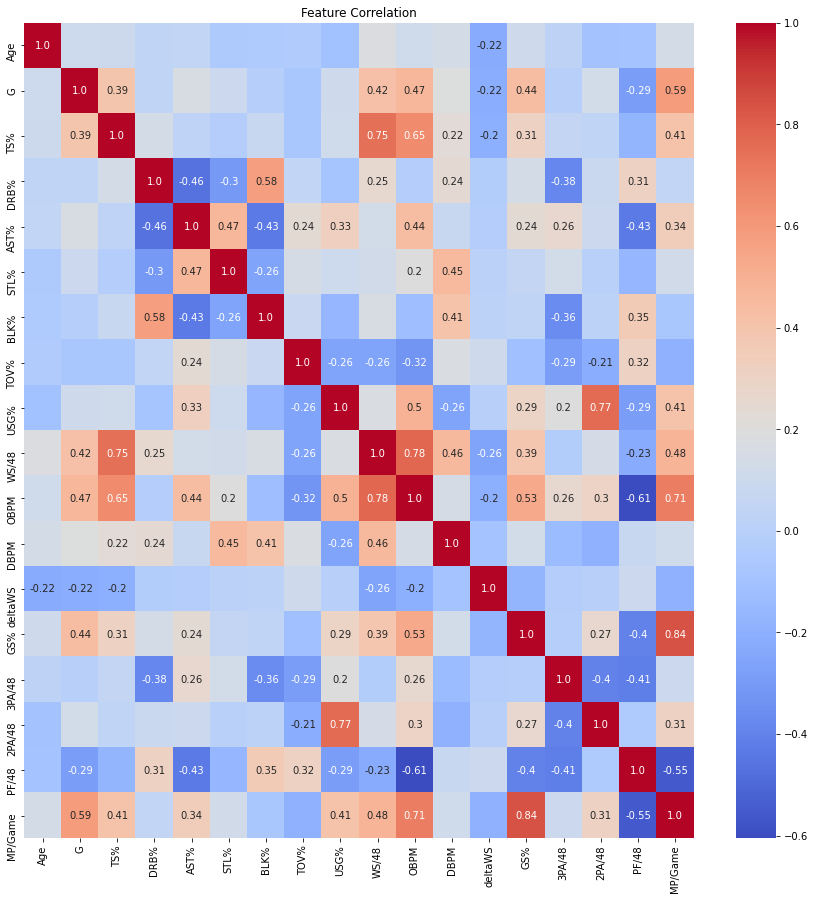

In [73]:
fig,ax_heatmap_2 = plt.subplots(1,1,figsize = (15,15))
features_numerical_2 = [i for i in deltaWS_df.columns.tolist() if ((deltaWS_df[i].dtype == 'float64') or (deltaWS_df[i].dtype == 'int32'))]
features_numerical_2.insert(0,'Age')
correl_2 = deltaWS_df[features_numerical_2].corr()
correl_annot_2 = correl_2.round(2)
correl_annot_2[correl_annot_2.abs() < 0.2] = ""
snsheatmap_2 = sns.heatmap(correl_2,annot = correl_annot_2, cmap = 'coolwarm',ax = ax_heatmap_2, fmt = '')
ax_heatmap_2.set_title('Feature Correlation')

In [74]:
deltaWS_df.to_csv('FinalDF.csv', index = False)

In [75]:
features = deltaWS_df.columns.tolist()
features.remove('deltaWS')
features.extend(['deltaWS'])
deltaWS_df = deltaWS_df[features]
deltaWS_df.head(5)

,Player ID,Year,Player,Pos,Age,Tm,G,Season,TS%,DRB%,...,USG%,WS/48,OBPM,DBPM,GS%,3PA/48,2PA/48,PF/48,MP/Game,deltaWS
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43.0,1990-91,0.499,23.4,...,22.1,0.079,-3.4,-1.2,0.000000,0.000000,19.200000,6.455172,6.744186,1.6
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71.0,1991-92,0.533,20.9,...,20.6,0.110,-2.3,-0.4,0.014085,0.000000,18.552463,6.783726,13.154930,-0.1
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75.0,1992-93,0.551,18.1,...,20.5,0.074,-2.4,-1.5,0.693333,0.036613,17.281465,6.919908,17.480000,-2.1
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13.0,1993-94,0.485,24.2,...,22.6,-0.032,-5.3,-2.2,0.000000,0.000000,16.603774,6.037736,12.230769,0.4
4,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82.0,1979-80,0.639,22.2,...,24.1,0.227,4.8,2.4,0.971545,0.015272,21.105950,3.298759,38.329268,-0.5


<h3> Distribution of the Year to Year change in WS of players </h3> 

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='deltaWS', ylabel='Density'>

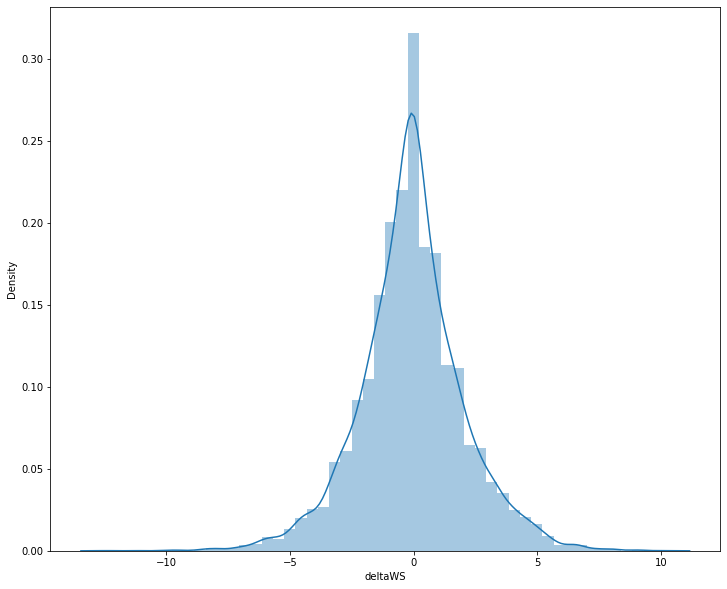

In [76]:
fig,ax_deltawsdist = plt.subplots(1,1,figsize = (12,10))
sns.distplot(deltaWS_df["deltaWS"], ax = ax_deltawsdist)

<h3> Separating Training Data and Testing Data </h3> 

To ensure there is no leakage in data we shall separate the dataset before starting the EDA

In [77]:
deltaWS_df.shape

(12247, 24)

In [78]:
training_data, testing_data = deltaWS_df[:9747], deltaWS_df[9747:]

<h3> Investigating how age impacts the ability of players to improve </h3> 

Null Hypothesis: Players decrease in ability to improve with increasing age

4 age groups will be used to investigate:
- <25
- 25 to 30
- 30 to 35
- greater than or equal to 35

In [80]:
training_data_age = training_data.copy()
training_data_age.loc[training_data_age["Age"].apply(lambda x: x < 25),"Age Group"] = "<25"
training_data_age.loc[training_data_age["Age"].apply(lambda x: ((x >= 25) & (x < 30))),"Age Group"] = "25 to 30"
training_data_age.loc[training_data_age["Age"].apply(lambda x: ((x >= 30) & (x < 35))),"Age Group"] = "30 to 35"
training_data_age.loc[training_data_age["Age"].apply(lambda x: x >= 35),"Age Group"] = ">= 35"

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age', ylabel='deltaWS'>

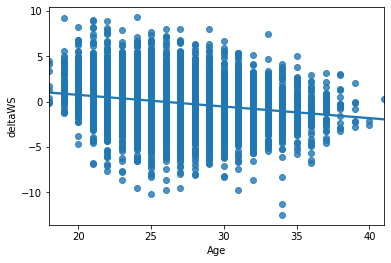

In [82]:
sns.regplot(training_data_age["Age"],training_data_age["deltaWS"])

As observed above, with increasing age, ability to improve does decrease. However within  a given age there is significant variation. 

In [ ]:
#investigate the zvalue between the age categories
